## 实验：遗传算法求解函数极值

### 实验概要

正如我们在之前的实验中讨论过的，遗传算法中每一条染色体/个体，对应着遗传算法的一个解决方案，一般我们用 **适应性函数**（Fitness Function）来衡量这个解决方案的优劣。所以从一个基因组到其解的适应度形成一个映射。可以把遗传算法的过程看作是一个在多元函数里面求最优解的过程。譬如：我们假设一个二元函数：$z=x-\frac{1}{9} x^{3}-\frac{1}{2} y^{2}$，其函数图像可绘制为：

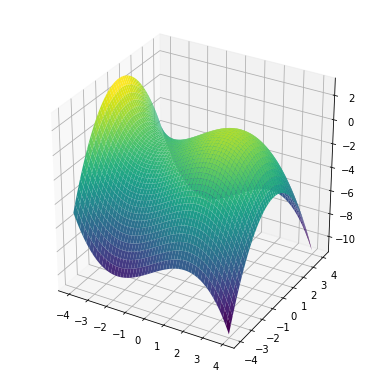

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

# 导入三维图形绘制库
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(5,5)) # 设置画布尺寸
ax = Axes3D(fig)                # 绘制三维图形

# 设置x，y取值范围
x = np.arange(-4, 4, 0.01)
y = np.arange(-4, 4, 0.01)

# 生成x，y网格坐标矩阵
x, y = np.meshgrid(x, y)

# 定义二元函数
z = x-(1./9)*x**3-(1./2)*y**2

# 设置图形配色风格
ax.plot_surface(x, y, z, cmap='viridis')

# 绘制图形
plt.show()

参照上图，你可以想象成这样一个场景，由多元函数形成的多维曲面里面，有数不清的 **山峰** ，而这些山峰所对应的就是局部最优解。而其中也会有一个 **山峰** 的海拔最高的，那么这个就是全局最优解。而遗传算法的任务就是尽量爬到最高峰，而不是陷落在一些小山峰。在本实验中，我们的求解过程均假设求解最大值。同时，值得注意的是遗传算法不一定要找 **最高的山峰**，如果问题的适应度评价越小越好的话，那么全局最优解就是函数的最小值，对应的，遗传算法所要找的就是 **最深的谷底**。

#### 遗传算法与 BP 神经网络最优化

实际上，遗传算法对函数极值求解，往往与神经网络最优化求解结合在一起。对于未知的非线性函数，仅通过函数的输入输出数据难以准确寻找函数极值。这类问题可以通过神经网络结合遗传算法求解，利用神经网络的非线性拟合能力和遗传算法的非线性寻优能力寻找函数极值。神经网络遗传算法函数极值寻优主要分为BP神经网络训练拟合和遗传算法极值寻优两步，算法流程如下所示：

<img src="./img/bp-ga.png">

- 神经网络训练拟合根据寻优函数的特点构建合适的 BP 神经网络，用非线性函数的输出数据训练 BP 网络，训练后的BP神经网络就可以预测函数输出。
- 遗传算法极值寻优把训练后的 BP 神经网络预测结果作为个体适应度值，通过选择、交叉和变异操作寻找函数的全局最优值及对应输入值。

### 实验目标

本实验从最基础的通过遗传算法实现一元函数机制求解开始。我们将通过二进制编码，采用 Python 实现遗传算法求解以下一元函数极值：

$$
f(x)=x \sin (10 \pi \times x)+2.0 \quad x \in[-1.2]
$$

让你进一步理解基本遗传算法的运行机理，为以后神经网络及最优化理论实践学习打下基础。

### 1. 导入库

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd

### 2. 问题定义

$$
f(x)=x \sin (10 \pi \times x)+2.0 \quad x \in[-1.2]
$$

其中，在区间 `[-1, 2]` 上有很多极大值和极小值，如果要求解其最大值或最小值，可以用遗传算法（Genetic Algorithm）实现求解。首先，我们需要定义求解目标函数，并绘制函数图形，代码如下：

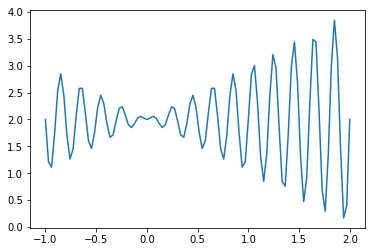

In [3]:
def fun(x):
    return x * np.sin(10*np.pi*x) + 2

# 在线性空间中以均匀步长生成数字序列 
Xs = np.linspace(-1, 2, 100)

# 以均匀序列为X轴，求解函数为Y轴，绘制函数图形
plt.plot(Xs, fun(Xs))

### 3. 初始化种群

遗传算法的一个特点是同时优化一批解（种群），使用 `np.random` 模块在 `[-1, 2]` 随机生成 10 个点并将其绘制出来。

x= 0.65, fit=2.64
x= 1.15, fit=0.87
x= 0.81, fit=2.21
x= 0.63, fit=2.56
x= 0.27, fit=2.21
x= 0.94, fit=1.13
x= 0.31, fit=1.88
x= 1.68, fit=3.17
x= 1.89, fit=2.53
x= 0.15, fit=1.85


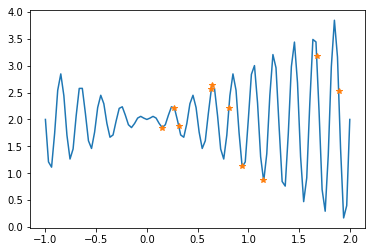

In [4]:
np.random.seed(0)
 
# 初始化原始种群
def ori_popular(num, _min=-1, _max=2):
    return np.random.uniform(_min, _max, num) # 范围[-1, 2)
 
population = ori_popular(10)

# 分别选取x值和对应的函数y值
for pop, fit in zip(population, fun(population)):
    print("x=%5.2f, fit=%.2f"%(pop, fit))

plt.plot(Xs, fun(Xs))
plt.plot(population, fun(population), '*')
plt.show()

$\uparrow$ 此时为初始化状态。

### 4. 二进制编码

编码，也就是由表现型到基因型，性征到染色体。二进制编码的缺点在于：对于一些连续函数的优化问题，由于其随机性使得其局部搜索能力较差，如：对于一些高精度的问题，当解迫近于最优解后，由于其变异后表现型变化很大，不连续，所以会远离最优解，达不到稳定。而格雷码能有效地防止这类现象。

In [5]:
# popular应该是float类型的列表
def encode(popular, _min=-1, _max=2, scale=2**18, bin_len=18):  
    """
        bin_len: 染色体序列长度
    """
    norm_data = (popular-_min) / (_max-_min) * scale
    # 转成二进制编码
    bin_data = np.array([np.binary_repr(x, 
               width=bin_len) for x in norm_data.astype(int)]) 
    return bin_data
 
chroms = encode(population)
for pop, chrom, fit in zip(population, chroms, fun(population)):
    print("x=%.2f, chrom=%s, fit=%.2f"%(pop, chrom, fit))

x=0.65, chrom=100011000111111100, fit=2.64
x=1.15, chrom=101101110001011010, fit=0.87
x=0.81, chrom=100110100100111010, fit=2.21
x=0.63, chrom=100010110111110101, fit=2.56
x=0.27, chrom=011011000111010010, fit=2.21
x=0.94, chrom=101001010101100101, fit=1.13
x=0.31, chrom=011100000000010110, fit=1.88
x=1.68, chrom=111001000100101100, fit=3.17
x=1.89, chrom=111101101011001010, fit=2.53
x=0.15, chrom=011000100010100100, fit=1.85


### 5. 解码和适应度计算
通过基因（染色体）得到个体的适应度值，也就是评判当前种群每个个体（解）表现好坏，要对编码解码后才能代入函数。这里直接使用函数的值作为适应度。

In [6]:
def decode(popular_gene, _min=-1, _max=2, scale=2**18):
    return np.array([(np.int(x, base=2)/scale*3)+_min for x in popular_gene])
 
fitness = fun(decode(chroms))
for pop, chrom, dechrom, fit in zip(population, chroms, decode(chroms), fitness):
    print("x=%5.2f, chrom=%s, dechrom=%.2f, fit=%.2f"%(pop, chrom, dechrom, fit))

x= 0.65, chrom=100011000111111100, dechrom=0.65, fit=2.64
x= 1.15, chrom=101101110001011010, dechrom=1.15, fit=0.87
x= 0.81, chrom=100110100100111010, dechrom=0.81, fit=2.21
x= 0.63, chrom=100010110111110101, dechrom=0.63, fit=2.56
x= 0.27, chrom=011011000111010010, dechrom=0.27, fit=2.21
x= 0.94, chrom=101001010101100101, dechrom=0.94, fit=1.13
x= 0.31, chrom=011100000000010110, dechrom=0.31, fit=1.88
x= 1.68, chrom=111001000100101100, dechrom=1.68, fit=3.17
x= 1.89, chrom=111101101011001010, dechrom=1.89, fit=2.53
x= 0.15, chrom=011000100010100100, dechrom=0.15, fit=1.85


In [7]:
# 保证所有的都为正
# 将最小的适应度调整到 0.000001，主要为了防止负数
fitness = fitness - fitness.min() + 0.000001 

### 6. 选择和交叉

这里使用轮盘赌进行选择操作。

轮盘赌选择方法又称：**比例选择方法**，其基本思想是：各个个体被选中的概率与其适应度大小成正比。具体操作如下：

1. 计算出群体中每个个体的适应度 $f(i=1,2,…,M)$，$M$ 为群体大小
2. 计算出每个个体被遗传到下一代群体中的概率
3. 计算出每个个体的累计概率（$q[i]$ 称为染色体 $x_{i}$ 的积累概率）
4. 在 `[0,1]` 区间内产生一个均匀分布的伪随机 $r$；
5. 若 $r<q[1]$，则选择个体 $1$，否则，选择个体 $k$，使得：$q[k-1]<rq[k]$
6. 重复 `4`、`5` 共 $M$ 次。

交叉就是让染色体相互交换基因，这里在染色体中间进行交叉，交叉概率默认为 `0.66`。

In [8]:
def SelectandCrossover(chroms, fitness, prob=0.6):
    probs = fitness/np.sum(fitness)  # 各个个体被选择的概率
    probs_cum = np.cumsum(probs)     # 概率累加分布
    
    # 产生均匀分布的伪随机
    each_rand = np.random.uniform(size=len(fitness))
    # 根据随机概率选择出新的基因编码
    newX = np.array([chroms[np.where(probs_cum > rand)[0][0]] for rand in each_rand])
    
    # 繁殖，随机配对（概率为0.6)
    pairs = np.random.permutation(int(len(newX)*prob//2*2)).reshape(-1, 2)
    center = len(newX[0])//2
    for i, j in pairs:
        
        # 在中间位置交叉
        x, y = newX[i], newX[j]
        newX[i] = x[:center] + y[center:]
        newX[j] = y[:center] + x[center:]
 
    return newX    

输出图形：

chrom=111101101000010110, dec= 1.89, fit=2.64
chrom=011100000011001010, dec= 0.31, fit=1.86
chrom=011100000010100100, dec= 0.31, fit=1.86
chrom=011000100000010110, dec= 0.15, fit=1.85
chrom=100011000111111100, dec= 0.65, fit=2.64
chrom=100011000111111100, dec= 0.65, fit=2.64
chrom=100011000111111100, dec= 0.65, fit=2.64
chrom=111101101011001010, dec= 1.89, fit=2.53
chrom=111001000100101100, dec= 1.68, fit=3.17
chrom=111101101011001010, dec= 1.89, fit=2.53


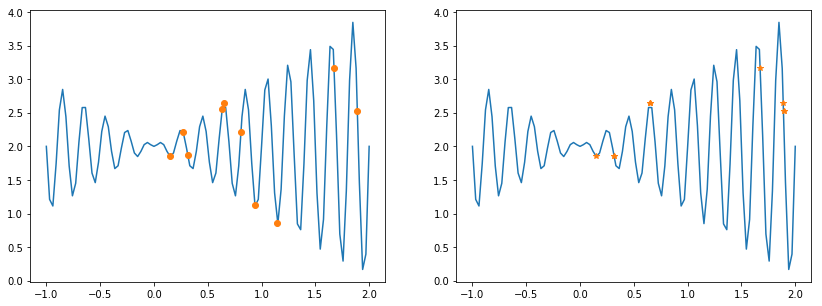

In [9]:
chroms = SelectandCrossover(chroms, fitness)
 
dechroms = decode(chroms)
fitness = fun(dechroms)
 
for gene, dec, fit in zip(chroms, dechroms, fitness):
    print("chrom=%s, dec=%5.2f, fit=%.2f"%(gene, dec, fit))

fig, (axs1, axs2) = plt.subplots(1, 2, figsize=(14, 5))
axs1.plot(Xs, fun(Xs))
axs1.plot(population, fun(population), 'o')
axs2.plot(Xs, fun(Xs))
axs2.plot(dechroms, fitness, '*')
plt.show()

### 7. 变异

如果现在我们从生物学的角度来看这个问题，那么请问：由上述过程产生的后代是否有和其父母一样的性状呢？答案是否。在后代的生长过程中，它们体内的基因会发生一些变化，使得它们与父母不同。这个过程我们称为 **变异**，它可以被定义为染色体上发生的随机变化，正是因为变异，种群中才会存在多样性。

In [10]:
def Mutate(chroms:np.array):
    # 设置变异概率为0.1
    prob = 0.1
    clen = len(chroms[0])
    m = {'0':'1', '1':'0'}
    newchroms = []
    each_prob = np.random.uniform(size=len(chroms))
    for i, chrom in enumerate(chroms):
        if each_prob[i] < prob:
            pos = np.random.randint(clen)    
            chrom = chrom[:pos] + m[chrom[pos]] + chrom[pos+1:]
        newchroms.append(chrom)
    return np.array(newchroms)

newchroms = Mutate(chroms)

### 8. 结果可视化

dec= 1.89, fit=2.64
dec= 0.31, fit=1.86
dec= 0.31, fit=1.86
dec= 0.15, fit=1.85
dec= 0.65, fit=2.64
dec= 0.65, fit=2.64
dec= 0.65, fit=2.64
dec= 1.89, fit=2.53
dec= 1.68, fit=3.17
dec= 1.89, fit=2.53
dec= 1.89, fit=2.64
dec= 0.31, fit=1.86
dec= 0.31, fit=1.86
dec= 0.15, fit=1.85
dec= 0.65, fit=2.64
dec= 0.65, fit=2.64
dec= 0.65, fit=2.64
dec= 1.89, fit=2.53
dec= 1.68, fit=3.17
dec= 1.89, fit=2.53


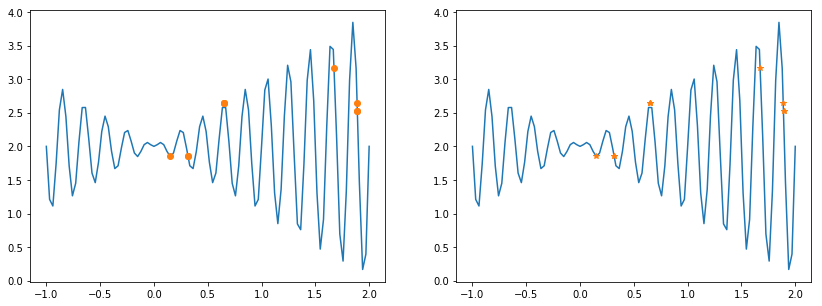

In [11]:
def PltTwoChroms(chroms1, chroms2, fitfun):
    Xs = np.linspace(-1, 2, 100)
    fig, (axs1, axs2) = plt.subplots(1, 2, figsize=(14, 5))
    dechroms = decode(chroms1)
    fitness = fitfun(dechroms)
    for dec, fit in zip(dechroms, fitness):
        print("dec=%5.2f, fit=%.2f"%(dec, fit))
    axs1.plot(Xs, fitfun(Xs))
    axs1.plot(dechroms, fitness, 'o')
    
    dechroms2 = decode(chroms2)
    fitness2 = fitfun(dechroms)
    for dec, fit in zip(dechroms, fitness):
        print("dec=%5.2f, fit=%.2f"%(dec, fit))
    axs2.plot(Xs, fitfun(Xs))
    axs2.plot(dechroms, fitness, '*')
    plt.show()

PltTwoChroms(chroms, newchroms, fun)

### 9. 遗传算法求解最大值

求解步骤如下：

1. 生成初始样本。调用初始化函数生成 100个 初始样本
2. 编码。调用编码函数对样本进行编码
3. 解码计算适应值。对每次迭代，调用函数计算适应度
4. 选择，交叉，变异
5. 结果可视化

dec= 1.46, fit=3.35
dec= 0.25, fit=2.24
dec= 1.22, fit=2.65
dec=-0.45, fit=2.45
dec= 1.83, fit=3.60
dec=-0.24, fit=2.24
dec=-0.26, fit=2.24
dec=-0.24, fit=2.24
dec=-0.65, fit=2.64
dec=-0.13, fit=1.90
dec=-0.82, fit=2.55
dec= 1.08, fit=2.67
dec=-0.71, fit=1.72
dec= 0.37, fit=1.69
dec=-0.05, fit=2.05
dec= 1.05, fit=3.05
dec= 0.57, fit=1.53
dec= 0.40, fit=1.99
dec= 0.57, fit=1.51
dec= 1.51, fit=1.35
dec= 0.82, fit=2.38
dec=-0.06, fit=2.05
dec=-0.45, fit=2.45
dec=-0.41, fit=2.12
dec= 1.10, fit=2.12
dec=-0.51, fit=1.86
dec= 0.81, fit=2.22
dec= 0.37, fit=1.71
dec= 0.11, fit=1.98
dec= 1.32, fit=1.14
dec=-0.67, fit=2.57
dec= 1.14, fit=0.88
dec= 0.70, fit=1.97
dec= 0.37, fit=1.68
dec=-0.24, fit=2.24
dec=-0.26, fit=2.24
dec=-0.24, fit=2.23
dec= 0.10, fit=1.98
dec= 0.10, fit=1.99
dec= 1.10, fit=2.14
dec= 0.73, fit=1.45
dec= 1.83, fit=3.56
dec=-0.82, fit=2.49
dec=-0.72, fit=1.60
dec=-0.64, fit=2.63
dec=-0.71, fit=1.79
dec= 1.89, fit=2.85
dec= 1.00, fit=2.08
dec= 0.40, fit=2.05
dec=-0.99, fit=1.61


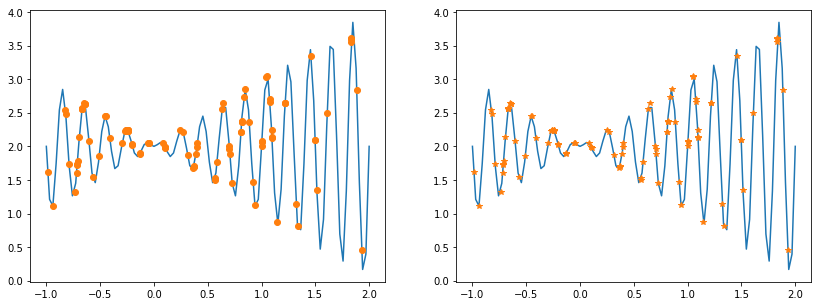

dec= 1.85, fit=3.83
dec= 1.85, fit=3.84
dec= 1.85, fit=3.84
dec= 1.86, fit=3.80
dec= 1.85, fit=3.84
dec= 1.86, fit=3.80
dec= 1.85, fit=3.84
dec= 1.84, fit=3.73
dec= 1.84, fit=3.80
dec= 1.85, fit=3.84
dec= 1.85, fit=3.84
dec= 1.86, fit=3.79
dec= 1.84, fit=3.78
dec= 1.85, fit=3.84
dec= 1.84, fit=3.73
dec= 1.85, fit=3.85
dec= 1.85, fit=3.84
dec= 1.86, fit=3.83
dec= 1.86, fit=3.80
dec= 1.85, fit=3.82
dec= 1.85, fit=3.82
dec= 1.85, fit=3.85
dec= 1.85, fit=3.84
dec= 1.85, fit=3.83
dec= 1.86, fit=3.79
dec= 1.86, fit=3.79
dec= 1.84, fit=3.77
dec= 1.85, fit=3.84
dec= 1.85, fit=3.83
dec= 1.85, fit=3.84
dec= 1.85, fit=3.84
dec= 1.85, fit=3.83
dec= 1.85, fit=3.84
dec= 1.86, fit=3.79
dec= 1.85, fit=3.83
dec= 1.85, fit=3.84
dec= 1.85, fit=3.84
dec= 1.84, fit=3.82
dec= 1.85, fit=3.84
dec= 1.86, fit=3.82
dec= 1.85, fit=3.83
dec= 1.85, fit=3.84
dec= 1.84, fit=3.81
dec= 1.85, fit=3.84
dec= 1.85, fit=3.84
dec= 1.85, fit=3.83
dec= 1.85, fit=3.83
dec= 1.84, fit=3.80
dec= 1.86, fit=3.80
dec= 1.85, fit=3.84


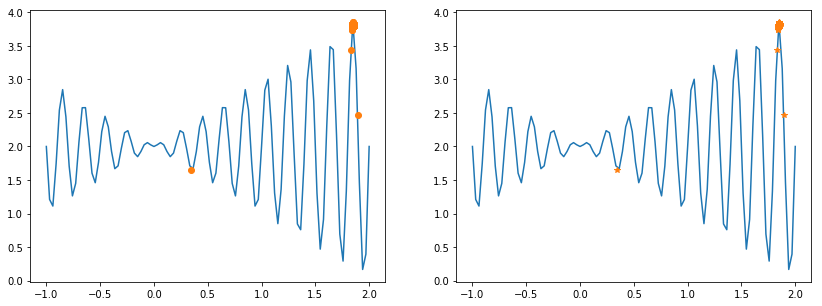

dec= 1.85, fit=3.84
dec= 1.85, fit=3.84
dec= 1.85, fit=3.85
dec= 1.86, fit=3.83
dec= 1.85, fit=3.85
dec= 1.84, fit=3.79
dec= 1.86, fit=3.83
dec= 1.85, fit=3.85
dec= 1.85, fit=3.84
dec= 1.85, fit=3.85
dec= 1.84, fit=3.78
dec= 1.85, fit=3.84
dec= 1.85, fit=3.84
dec= 1.85, fit=3.85
dec= 1.84, fit=3.81
dec= 1.85, fit=3.84
dec= 1.85, fit=3.84
dec= 1.85, fit=3.84
dec= 1.84, fit=3.81
dec= 1.85, fit=3.84
dec= 1.85, fit=3.84
dec= 1.84, fit=3.81
dec= 1.85, fit=3.84
dec= 1.83, fit=3.51
dec= 1.85, fit=3.83
dec= 1.85, fit=3.84
dec= 1.85, fit=3.84
dec= 1.85, fit=3.85
dec= 1.67, fit=3.36
dec= 1.84, fit=3.78
dec= 1.84, fit=3.79
dec= 1.84, fit=3.81
dec= 1.84, fit=3.79
dec= 1.84, fit=3.79
dec= 1.85, fit=3.84
dec= 1.85, fit=3.84
dec= 1.85, fit=3.85
dec= 1.85, fit=3.84
dec= 1.85, fit=3.85
dec= 1.85, fit=3.85
dec= 1.85, fit=3.85
dec= 1.85, fit=3.84
dec= 1.85, fit=3.85
dec= 1.86, fit=3.83
dec= 1.84, fit=3.82
dec= 1.85, fit=3.85
dec= 1.85, fit=3.85
dec= 1.85, fit=3.84
dec= 1.84, fit=3.81
dec= 1.85, fit=3.85


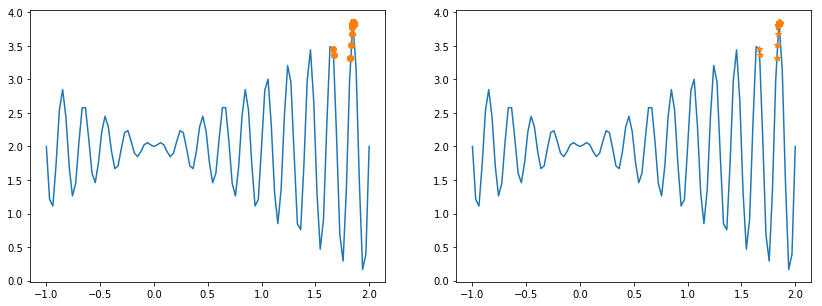

dec= 1.85, fit=3.85
dec= 1.83, fit=3.57
dec= 1.85, fit=3.85
dec= 1.85, fit=3.85
dec= 1.86, fit=3.82
dec= 1.85, fit=3.85
dec= 1.85, fit=3.85
dec= 1.85, fit=3.85
dec= 1.85, fit=3.85
dec= 1.85, fit=3.85
dec= 1.85, fit=3.85
dec= 1.85, fit=3.84
dec= 1.85, fit=3.85
dec= 1.85, fit=3.84
dec= 1.86, fit=3.83
dec= 1.84, fit=3.80
dec= 1.86, fit=3.82
dec= 1.85, fit=3.85
dec= 1.85, fit=3.85
dec= 1.66, fit=3.62
dec= 1.86, fit=3.83
dec= 1.91, fit=1.65
dec= 1.86, fit=3.82
dec= 1.85, fit=3.85
dec= 1.86, fit=3.78
dec= 1.85, fit=3.85
dec= 1.86, fit=3.82
dec= 1.85, fit=3.85
dec= 1.85, fit=3.85
dec= 1.86, fit=3.83
dec= 1.85, fit=3.84
dec= 1.85, fit=3.85
dec= 1.85, fit=3.85
dec= 1.85, fit=3.85
dec= 1.85, fit=3.85
dec= 1.94, fit=0.10
dec= 1.85, fit=3.85
dec= 1.86, fit=3.79
dec= 1.85, fit=3.84
dec= 1.84, fit=3.81
dec= 1.85, fit=3.85
dec= 1.10, fit=1.99
dec= 1.85, fit=3.84
dec= 1.85, fit=3.85
dec= 1.85, fit=3.84
dec= 1.85, fit=3.85
dec= 1.85, fit=3.85
dec= 1.85, fit=3.84
dec= 1.84, fit=3.79
dec= 1.48, fit=3.04


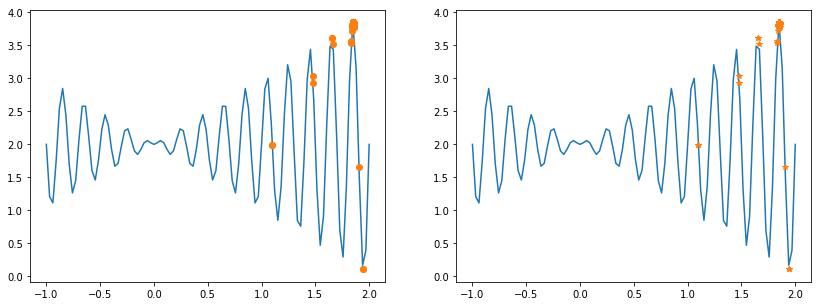

dec= 1.86, fit=3.82
dec= 1.86, fit=3.82
dec= 1.85, fit=3.84
dec= 1.85, fit=3.85
dec= 1.86, fit=3.83
dec= 1.83, fit=3.57
dec= 1.85, fit=3.84
dec= 1.86, fit=3.82
dec= 1.86, fit=3.82
dec= 1.86, fit=3.80
dec= 1.86, fit=3.82
dec= 1.86, fit=3.83
dec= 1.84, fit=3.81
dec= 1.94, fit=0.22
dec= 1.84, fit=3.82
dec= 1.86, fit=3.83
dec= 1.83, fit=3.54
dec= 1.85, fit=3.85
dec= 1.86, fit=3.82
dec= 1.86, fit=3.83
dec= 1.86, fit=3.83
dec= 1.84, fit=3.82
dec= 1.84, fit=3.82
dec= 1.84, fit=3.80
dec= 1.67, fit=3.41
dec= 1.85, fit=3.84
dec= 1.86, fit=3.82
dec= 1.86, fit=3.83
dec= 1.84, fit=3.82
dec= 1.84, fit=3.81
dec= 1.84, fit=3.82
dec= 1.84, fit=3.82
dec= 1.85, fit=3.85
dec= 1.85, fit=3.84
dec= 1.85, fit=3.85
dec= 1.84, fit=3.81
dec= 1.84, fit=3.81
dec= 1.86, fit=3.83
dec= 1.84, fit=3.81
dec= 1.86, fit=3.83
dec= 1.86, fit=3.82
dec= 1.84, fit=3.82
dec= 1.84, fit=3.80
dec= 1.84, fit=3.82
dec= 1.86, fit=3.83
dec= 1.86, fit=3.83
dec= 1.84, fit=3.81
dec= 1.86, fit=3.82
dec= 1.85, fit=3.85
dec= 1.83, fit=3.54


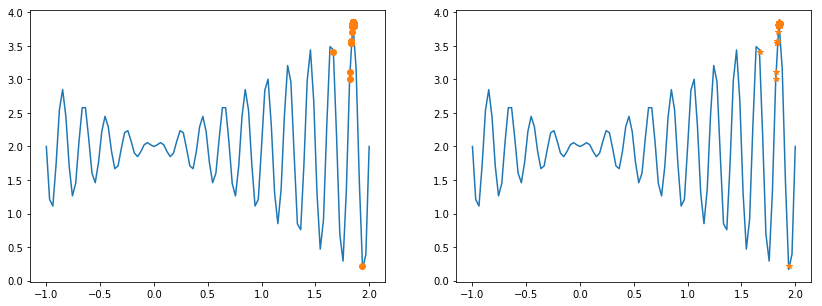

In [12]:
np.random.seed(0)
population = ori_popular(100)
chroms = encode(population)
 
for i in range(1000):
    fitness = fun(decode(chroms))
    fitness = fitness - fitness.min() + 0.000001 # 保证所有的都为正
    newchroms = Mutate(SelectandCrossover(chroms, fitness))
    if i % 300 == 1:
        PltTwoChroms(chroms, newchroms, fun)
    chroms = newchroms
    
PltTwoChroms(chroms, newchroms, fun)

$\uparrow$ 可以看到，经过 1000 次迭代，最后样本点大多数都集中在了 `[-1.0, 2.0]` 区间的函数最大值处。从计算得到的值可以看到，区间 `[-1.0,2.0]` 之间极值点在 `dec=0.85` 附近，最大值在 `3.80` 附近。

### 实验小结

在本实验中，你实现了通过遗传算法求解函数极值。